## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [6]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_test = np.log1p(df_test.price.values)
y_val = np.log1p(df_val.price.values)

del df_train['price']
del df_test['price']
del df_val['price']

Now, use `DictVectorizer` to turn train and validation into matrices:


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   latitude                        48895 non-null  float64
 2   longitude                       48895 non-null  float64
 3   room_type                       48895 non-null  object 
 4   price                           48895 non-null  int64  
 5   minimum_nights                  48895 non-null  int64  
 6   number_of_reviews               48895 non-null  int64  
 7   reviews_per_month               48895 non-null  float64
 8   calculated_host_listings_count  48895 non-null  int64  
 9   availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 3.7+ MB


In [15]:
features = columns[:-1]
features

['neighbourhood_group',
 'room_type',
 'latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [16]:
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [17]:
from sklearn.feature_extraction import DictVectorizer

In [18]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [20]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [21]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



C:\Users\tevfk\anaconda3\envs\mlbook_camp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [25]:
from  sklearn.metrics import mean_squared_error

In [26]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.46156323035140573

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [28]:
from tqdm.auto import tqdm

In [29]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])


  0%|          | 0/20 [00:00<?, ?it/s]

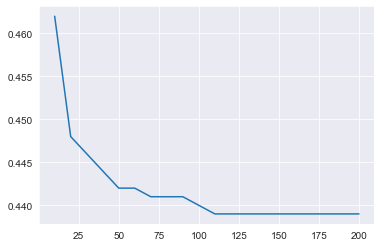

In [30]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

In [31]:
scores = []

rf = RandomForestRegressor(n_estimators=0,
                           random_state=1, n_jobs=-1,
                           warm_start=True)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

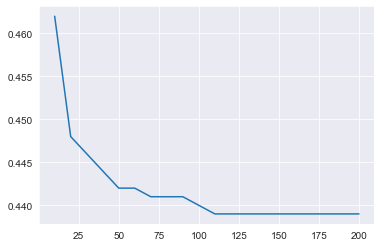

In [32]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [33]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

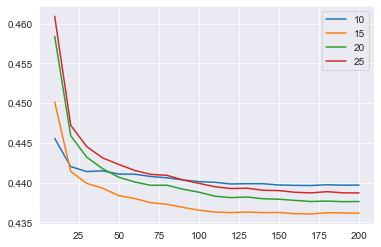

In [34]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [35]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20,
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [36]:
rf.feature_importances_

array([7.62639474e-02, 3.01019255e-02, 1.52775354e-01, 1.54100960e-01,
       5.32519176e-02, 2.64845849e-04, 9.65959537e-04, 3.40472718e-02,
       1.16609902e-03, 8.40278947e-05, 4.15942415e-02, 5.44303877e-02,
       3.91898194e-01, 4.03202776e-03, 5.02284130e-03])

In [37]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances

C:\Users\tevfk\anaconda3\envs\mlbook_camp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,availability_365,0.076264
1,calculated_host_listings_count,0.030102
2,latitude,0.152775
3,longitude,0.154101
4,minimum_nights,0.053252
5,neighbourhood_group=Bronx,0.000265
6,neighbourhood_group=Brooklyn,0.000966
7,neighbourhood_group=Manhattan,0.034047
8,neighbourhood_group=Queens,0.001166
9,neighbourhood_group=Staten Island,0.000084


In [38]:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
12,room_type=Entire home/apt,0.391898
3,longitude,0.154101
2,latitude,0.152775
0,availability_365,0.076264
11,reviews_per_month,0.054430


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [40]:
import xgboost as xgb

In [42]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

C:\Users\tevfk\anaconda3\envs\mlbook_camp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [44]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [45]:
scores = {}

In [46]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [47]:
scores['eta=0.3'] = parse_xgb_output(output)

Now change `eta` first to `0.1` and then to `0.01`

In [48]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [49]:
scores['eta=0.1'] = parse_xgb_output(output)

In [51]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [52]:
scores['eta=0.01'] = parse_xgb_output(output)

(50.0, 100.0)

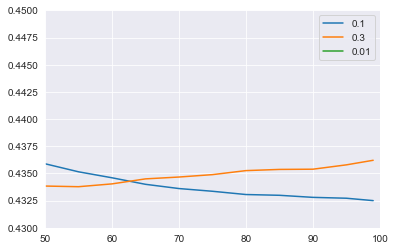

In [56]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.plot(scores['eta=0.01'].num_iter, scores['eta=0.01'].val_auc,
        label='0.01')
plt.legend()

plt.ylim([0.43, 0.45])
plt.xlim([50, 100])


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

